In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv( "/content/drive/MyDrive/HorizonHW/Project/spam.csv", usecols=['v1','v2'], encoding='latin-1' )

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
map = { 'spam': 1, 'ham': 0 }
df[ 'spam' ] = df[ 'v1' ].map( map )

In [ ]:
df.head()

,v1,v2,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
print( len( df[ df.spam == 1 ] ) )
print( len( df[ df.spam == 0 ] ) )

747
4825


In [ ]:
features = df[ 'v2' ].values.tolist()
labels = df[ 'spam' ].values.tolist()

In [ ]:
#Sets the size of the train, validation, and check sets and splits the data up
training_size = int( len( features ) * 0.7 )
val_size = int( len( features ) * 0.9 )

training_features = features[ 0 : training_size ]
training_labels = labels[ 0 : training_size ]
val_features = features[ training_size : val_size ]
val_labels = labels[ training_size : val_size ]

check_features = features[ val_size : ]
check_labels = labels[ val_size : ]

#Converts labels into np arrays for use in the network
training_labels_f = np.array( training_labels )
val_labels_f = np.array( val_labels )

In [ ]:
#Initializes information necessary for tokenization
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [ ]:
#Creates a word index based on the training features and orders the words in each feature appropriately
tokenizer = Tokenizer( num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts( training_features )
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences( training_features )

In [ ]:
#Padding is added to ensure each string is of the same length
pad = pad_sequences( sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type )

#Transforms texts to sequence of integers
val_sequences = tokenizer.texts_to_sequences( val_features )
val_padded = pad_sequences( val_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type )

In [ ]:
#Architecture of the Neural Network
model = tf.keras.Sequential( [tf.keras.layers.Embedding( vocab_size, embedding_dim, input_length = max_length ), 
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense( 6, activation = 'relu' ),
                              tf.keras.layers.Dense( 1, activation = 'sigmoid' )
                              ] )

model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           16000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 9606      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 25,613
Trainable params: 25,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch = 20
history = model.fit( pad, training_labels_f, epochs = epoch, validation_data = ( val_padded, val_labels_f ) )

Epoch 1/20
122/122 [==============================] - 1s 4ms/step - loss: 0.4204 - accuracy: 0.8618 - val_loss: 0.3206 - val_accuracy: 0.8600
Epoch 2/20
122/122 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.8667 - val_loss: 0.1962 - val_accuracy: 0.8600
Epoch 3/20
122/122 [==============================] - 0s 3ms/step - loss: 0.1648 - accuracy: 0.8995 - val_loss: 0.1682 - val_accuracy: 0.9650
Epoch 4/20
122/122 [==============================] - 1s 5ms/step - loss: 0.1431 - accuracy: 0.9715 - val_loss: 0.1515 - val_accuracy: 0.9677
Epoch 5/20
122/122 [==============================] - 0s 3ms/step - loss: 0.1231 - accuracy: 0.9785 - val_loss: 0.0798 - val_accuracy: 0.9785
Epoch 6/20
122/122 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.9854 - val_loss: 0.0593 - val_accuracy: 0.9811
Epoch 7/20
122/122 [==============================] - 0s 3ms/step - loss: 0.0305 - accuracy: 0.9900 - val_loss: 0.0602 - val_accuracy: 0.9811
Epoch 

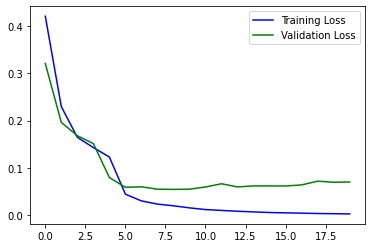

In [ ]:
plt.plot( history.history[ 'loss' ], '-b', label = 'Training Loss' )
plt.plot( history.history[ 'val_loss' ], '-g', label = 'Validation Loss' )
plt.legend()

In [ ]:
#Counts the amount of times a certain number shows up in a list; Used to find the number of positives and negatives in the test list|
def count( num, l ):
  count = 0
  for x in l:
    if x == num:
      count += 1
  return count


In [ ]:
#Converts the check set into tokenized and padded sequences
padding_type = 'post'
sample_sequences = tokenizer.texts_to_sequences( check_features )
checks_padded = pad_sequences( sample_sequences, padding = padding_type, maxlen = max_length )

classes = model.predict( checks_padded )
classes_rounded = classes

#Initializes variables to check accuracy of the model
unsure = 0
correct = 0
wrong = 0

#Initializes some variables to track positives/negatives and true and false positives/negatives
pos = count( 1, check_labels )
neg = count( 0, check_labels)
truePos = 0
trueNeg = 0
falsePos = 0
falseNeg = 0

#Runs through the check array and finds the number of unsure, correct, and incorrect predictions
for x in range( len( check_features ) ):
  if classes[x] < 0.4:
    classes_rounded[x] = 0
  elif classes[x] > 0.6:
    classes_rounded[x] = 1
  else:
    classes_rounded[x] = 2
  
  if classes_rounded[x] == 2:
    unsure += 1
  elif classes_rounded[x] == check_labels[x]:
    if check_labels[x] == 0:
      trueNeg += 1
    else:
      truePos += 1
    correct += 1
  else:
    if check_labels[x] == 0:
      falsePos += 1
    else:
      falseNeg += 1
    wrong += 1

print( "The model made " + str( correct ) + " correct predictions, " + str( wrong ) + " wrong predictions, " + " and was unsure " + str( unsure ) + " times." )

The model made 551 correct predictions, 5 wrong predictions,  and was unsure 2 times.


In [ ]:
#Calculates various evaluation metrics for the model
accuracy = correct / ( correct + wrong + unsure )
precision = truePos / ( truePos + falsePos )
recall = truePos / ( truePos + falseNeg )
f1 = 2 * ( ( precision * recall ) / ( precision + recall ) )

#Prints out the metrics
print( "The accuracy was " + str( accuracy ) )
print( "The precision was " + str( precision ) )
print( "The recall was " + str( recall ) )
print( "The f1 was " + str( f1 ) )

The accuracy was 0.9874551971326165
The precision was 0.9852941176470589
The recall was 0.9436619718309859
The f1 was 0.9640287769784172


486
